In [1]:
import json
import requests 
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#loading .env variables
load_dotenv()


True

In [3]:
API_KEY = os.getenv("NODE_API_KEY")

In [4]:
#importing the BTC close data from Yahoo Finance
import yfinance as yf
crypto =['BTC-USD', 'ETH-USD']
# Crypto Data
crypto_close = yf.download(crypto, group_by='Ticker', period='10y')
# Create CSV of ticker data
crypto_close.to_csv('crypto.csv')
crypto_close = crypto_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
crypto_close = pd.read_csv('crypto.csv', header=[0, 1])
crypto_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
crypto_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(crypto_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
crypto_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
crypto_close.index.name = None
# Drop Null Information
crypto_close = crypto_close.dropna()
# Sort Multi-Index To Match Weights
crypto_close = crypto_close.reindex(sorted(crypto_close.columns), axis=1)

# Removing Multi-index by joining level 1 with level 2 
crypto_close.columns = ['_'.join(col) for col in crypto_close.columns]


#Creating new DF with only the BTC specific columns needed
btc_close = crypto_close.loc[:, crypto_close.columns.intersection(['BTC-USD_Adj Close','BTC-USD_Close'])]

#Droping adj close 
btc_close.drop(columns = ["BTC-USD_Adj Close"], inplace = True)

btc_close.head()

[*********************100%***********************]  2 of 2 completed


,BTC-USD_Close
2015-08-07,279.584991
2015-08-08,260.997009
2015-08-09,265.083008
2015-08-10,264.470001
2015-08-11,270.385986


In [5]:
#defining functions for creating glassnode Dataframes


In [6]:
#creating a DataFrame
new_ad = requests.get('https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count',
                           params = {'a':'BTC', 'i':'1w', 'api_key': API_KEY})


new_address = pd.read_json(new_ad.text, convert_dates = ["t"])

new_address.set_index('t', inplace = True)
new_address.rename_axis(None, inplace = True)
new_address.rename(columns = {"v":'Daily Change'}, errors = "raise", inplace = True)
new_address.head()

,Daily Change
2008-12-29,1
2009-01-05,168
2009-01-12,813
2009-01-19,904
2009-01-26,797


In [7]:
 #Joining the two data frames together
new_address_join = pd.concat([btc_close, new_address],axis = 1, join = "inner")
new_address_join.tail()   

,BTC-USD_Close,Daily Change
2021-08-02,39201.945312,2575505
2021-08-09,46365.402344,2628837
2021-08-16,46004.484375,2688003
2021-08-23,49546.148438,2686236
2021-08-30,47054.984375,2824558


In [8]:
# Creating the EMA and PCT change for the new address
new_address_join['PCT_Change'] = new_address_join['Daily Change'].pct_change()
new_address_join['20EMA'] = new_address_join['Daily Change'].ewm(span=20, adjust=False).mean()
new_address_join['50EMA'] = new_address_join['Daily Change'].ewm(span=50, adjust=False).mean()
new_address_join['100EMA'] = new_address_join['Daily Change'].ewm(span=100, adjust=False).mean()
new_address_join.head()

,BTC-USD_Close,Daily Change,PCT_Change,20EMA,50EMA,100EMA
2015-08-10,264.470001,1006651,NaN,1.006651e+06,1.006651e+06,1.006651e+06
2015-08-17,257.976013,1082635,0.075482,1.013888e+06,1.009631e+06,1.008156e+06
2015-08-24,210.494995,1061387,-0.019626,1.018411e+06,1.011660e+06,1.009210e+06
2015-08-31,230.056000,1105650,0.041703,1.026720e+06,1.015346e+06,1.011119e+06
2015-09-07,239.847000,1169909,0.058119,1.040357e+06,1.021408e+06,1.014264e+06


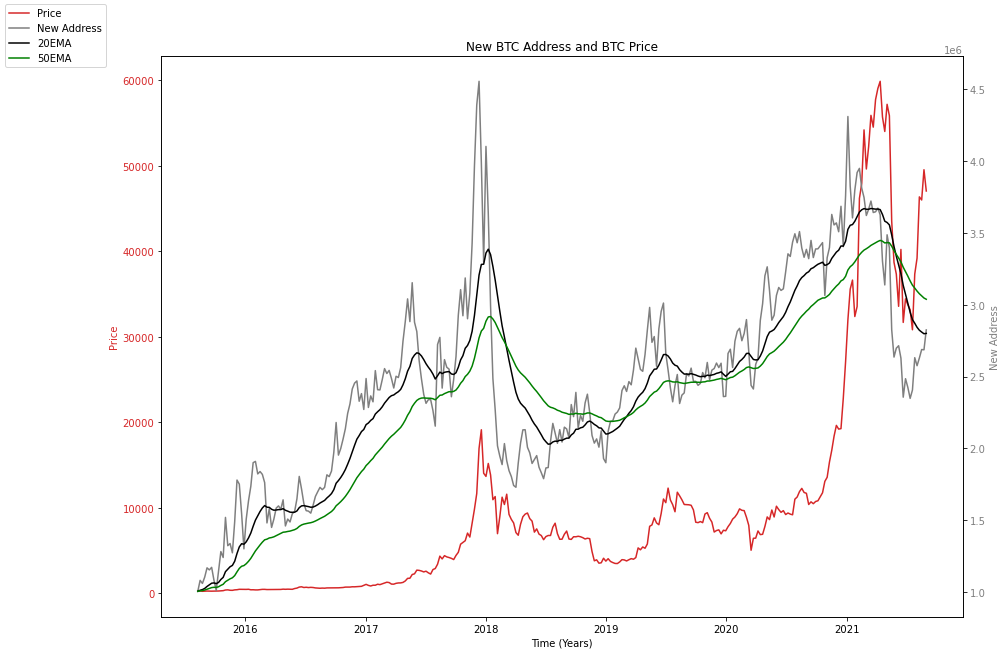

In [11]:
#ploting the Charts using Matplotlob
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel('Price', color=color)
ax1.plot(new_address_join['BTC-USD_Close'], color=color, label = 'Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:grey'
ax2.set_ylabel('New Address', color=color)  # we already handled the x-label with ax1
ax2.plot(new_address_join['Daily Change'], color=color, label = 'New Address' )
ax2.plot(new_address_join['20EMA'], color='black', label = '20EMA')
ax2.plot(new_address_join['50EMA'], color='green', label = '50EMA')
#ax2.plot(new_address_join['100EMA'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc="upper left")
plt.title("New BTC Address and BTC Price")
fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

In [12]:
# creating signals for EMA cross 
# Grab just the `date` and `close` from the IEX dataset
signals_df = new_address_join.copy()
short_window = 20
long_window = 50


# Initialize the new `Signal` column
signals_df['Signal'] = 0.0

# Generate the trading signal (1 or 0) to when the short window is less than the long
# Note: Use 1 when the SMA50 is less than SMA100 and 0 for when it is not.
signals_df["Signal"][short_window:] = np.where(
    signals_df["20EMA"][short_window:] > signals_df["50EMA"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Print the DataFrame
signals_df.tail()

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,BTC-USD_Close,Daily Change,PCT_Change,20EMA,50EMA,100EMA,Signal,Entry/Exit
2021-08-02,39201.945312,2575505,-0.021233,2.842709e+06,3.094507e+06,3.033153e+06,0.0,0.0
2021-08-09,46365.402344,2628837,0.020707,2.822340e+06,3.076245e+06,3.025147e+06,0.0,0.0
2021-08-16,46004.484375,2688003,0.022507,2.809546e+06,3.061020e+06,3.018471e+06,0.0,0.0
2021-08-23,49546.148438,2686236,-0.000657,2.797802e+06,3.046323e+06,3.011892e+06,0.0,0.0
2021-08-30,47054.984375,2824558,0.051493,2.800351e+06,3.037626e+06,3.008182e+06,0.0,0.0
